## Steps in building a machine learning model

1. Get the Data
2. Data Check
3. Split the Data (Train/Validation/Test)
4. EDA and Feature Importance
5. Training and model selection
6. Select a Final Model
7. Final model evaluation

It has to change the path of the data according to the location of the folder of the repo.

### 1. Get the Data

The information about the data set is in the "01 Data" folder. Check for the description of the columns.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split    

# import warnings
# warnings.filterwarnings('ignore')

/Users/fdl/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r'/Users/fdl/Repos/ML-ZoomCamp-Capstone-project-2/01 Data/Exam_Score_Prediction.csv')

df.columns

Index(['student_id', 'age', 'gender', 'course', 'study_hours',
       'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality',
       'study_method', 'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

### 2. Data Check

Exploration of the dataset (values for the different types of variables, missing values, max and min values).

In [3]:
# We can see if there are missing values and data types
# There is no missing values in this dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [68]:
# Review columns data types
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
numerical_columns.remove('student_id')  # remove student_id from numerical columns

# number of unique values in categorical columns
print("Number of unique values in categorical columns:")
df[categorical_columns].nunique()

Number of unique values in categorical columns:


gender             3
course             7
internet_access    2
sleep_quality      3
study_method       5
facility_rating    3
exam_difficulty    3
dtype: int64

In [6]:
# different values in categorical columns
for column in categorical_columns:
    print(f'Column: {column}')
    print(df[column].value_counts())
    print('-----------------------')

Column: gender
gender
other     6726
male      6695
female    6579
Name: count, dtype: int64
-----------------------
Column: course
course
bca        2902
ba         2896
b.sc       2878
b.com      2864
bba        2836
diploma    2826
b.tech     2798
Name: count, dtype: int64
-----------------------
Column: internet_access
internet_access
yes    16988
no      3012
Name: count, dtype: int64
-----------------------
Column: sleep_quality
sleep_quality
average    6694
poor       6687
good       6619
Name: count, dtype: int64
-----------------------
Column: study_method
study_method
self-study       4079
online videos    4069
coaching         4036
group study      3922
mixed            3894
Name: count, dtype: int64
-----------------------
Column: facility_rating
facility_rating
medium    6760
low       6638
high      6602
Name: count, dtype: int64
-----------------------
Column: exam_difficulty
exam_difficulty
moderate    9878
easy        6141
hard        3981
Name: count, dtype: int64
---

In [7]:
# Summary statistics for numerical columns
df[numerical_columns].describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


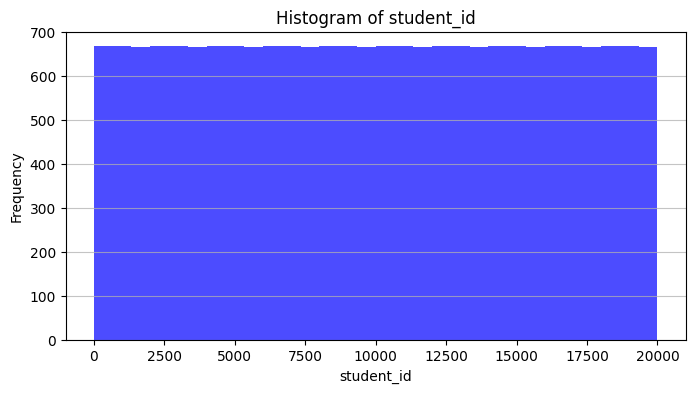

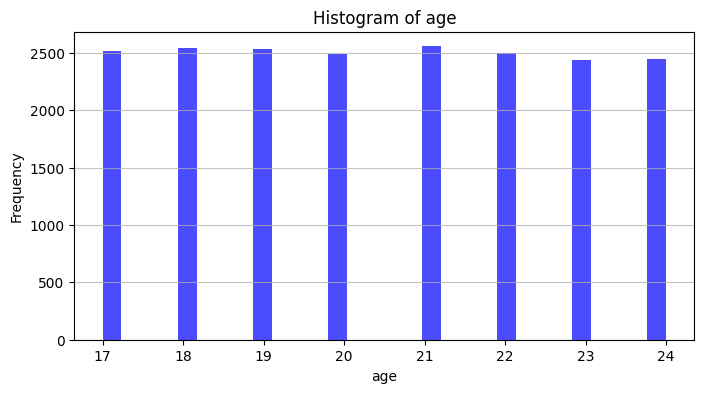

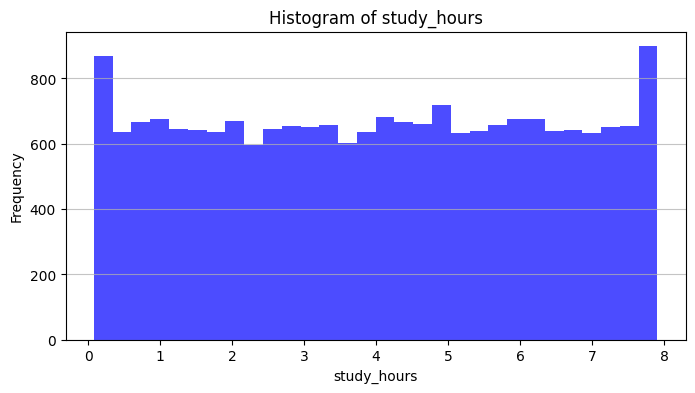

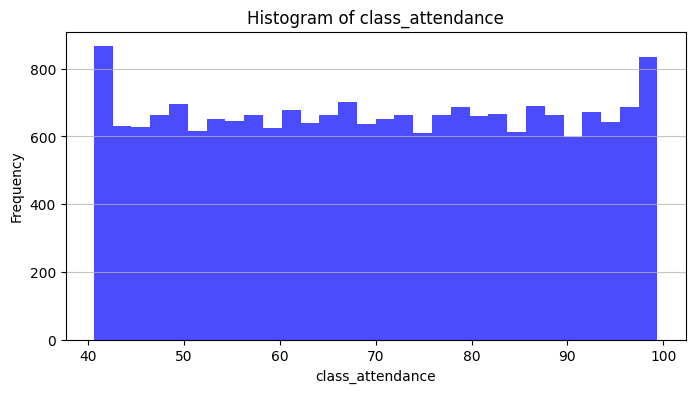

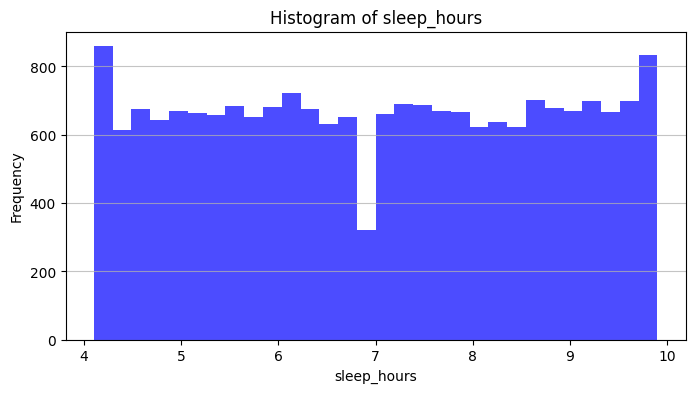

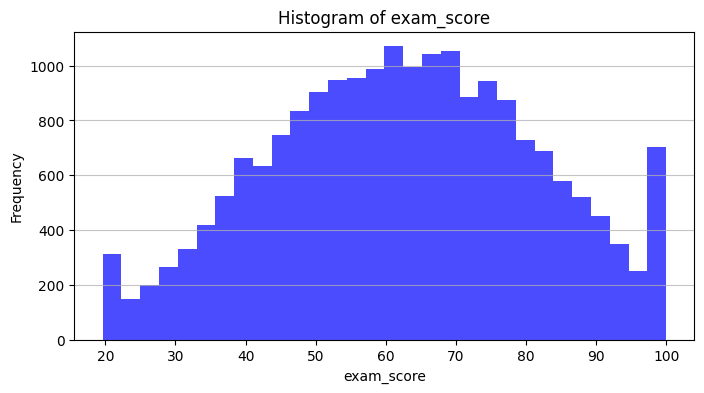

In [8]:
for column in numerical_columns:
    plt.figure(figsize=(8,4))
    plt.hist(df[column].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [9]:
# data preparation checks
print(df.isnull().sum())

student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


In [11]:
# rename target
df = df.rename(columns={'exam_score': 'y'})

### 3. Split data(train/validation/test)

Typical split: 60% training, 20% validation and 20% test.

In [151]:
# train test split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train.shape, df_val.shape, df_test.shape

((12000, 13), (4000, 13), (4000, 13))

In [38]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

### 4. EDA and Future Engineering
We review correlations and future engineering for the variables.

In [ ]:
numerical_columns.remove('exam_score')
numerical_columns.append('y')

In [19]:
# correlation analysis

x_var = []
y_var = []
correl = []

df_corr = df_train.copy()
for x in df_corr[numerical_columns].corr().index:
    for y in df_corr[numerical_columns].corr().columns:
        if x != y:
            x_var.append(x)
            y_var.append(y)
            correl.append(df_corr[numerical_columns].corr().loc[x, y])

correlation_df = pd.DataFrame({'x': x_var, 'y': y_var, 'correlation': correl})
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
correlation_df.drop_duplicates(subset=['correlation'], inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
print(correlation_df.head(5))
print('-----------------------')
print(correlation_df.tail(5))

             x                 y  correlation
0  study_hours                 y     0.716945
1            y  class_attendance     0.309128
2            y       sleep_hours     0.126649
3          age  class_attendance     0.007217
4            y               age     0.003812
-----------------------
                   x            y  correlation
10        student_id  study_hours    -0.003014
11       sleep_hours          age    -0.005382
12  class_attendance  study_hours    -0.006848
13       study_hours  sleep_hours    -0.009670
14               age   student_id    -0.013133


In [20]:
# correlation analysis
numerical_columns.remove('y')
x_var = []
y_var = []
correl = []

df_corr = df_train.copy()
for x in df_corr[numerical_columns].corr().index:
    for y in df_corr[numerical_columns].corr().columns:
        if x != y:
            x_var.append(x)
            y_var.append(y)
            correl.append(df_corr[numerical_columns].corr().loc[x, y])

correlation_df = pd.DataFrame({'x': x_var, 'y': y_var, 'correlation': correl})
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
correlation_df.drop_duplicates(subset=['correlation'], inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
print(correlation_df.head(5))
print('-----------------------')
print(correlation_df.tail(5))

             x                 y  correlation
0          age  class_attendance     0.007217
1  sleep_hours  class_attendance     0.003191
2   student_id  class_attendance     0.002233
3          age       study_hours    -0.000780
4   student_id       sleep_hours    -0.001436
-----------------------
             x                 y  correlation
5  study_hours        student_id    -0.003014
6  sleep_hours               age    -0.005382
7  study_hours  class_attendance    -0.006848
8  study_hours       sleep_hours    -0.009670
9          age        student_id    -0.013133


There is no a correlation grater than 0.5 or less than -0.5, so we are using all variables

In [21]:
# Function to calculate IQR and detect outliers
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

outliers = detect_outliers_iqr(df_train, numerical_columns)

# Display the number of outliers in each column
for col, outlier_data in outliers.items():
    print(f"{col}: {len(outlier_data)} outliers detected")

student_id: 0 outliers detected
age: 0 outliers detected
study_hours: 0 outliers detected
class_attendance: 0 outliers detected
sleep_hours: 0 outliers detected


In [ ]:
# transform categorical columns into numerical via one-hot encoding
for col in categorical_columns:
    for vals in df[col].unique():
        df[ col + '_' + str(vals)] = (df[col]==vals).astype(int)

In [34]:
df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,...,study_method_coaching,study_method_self-study,study_method_mixed,study_method_online videos,facility_rating_low,facility_rating_medium,facility_rating_high,exam_difficulty_moderate,exam_difficulty_easy,exam_difficulty_hard
0,16114,21,male,b.sc,5.70,60.5,yes,7.2,good,group study,...,0,0,0,0,1,0,0,1,0,0
1,18794,21,female,diploma,7.77,52.2,yes,4.6,good,coaching,...,1,0,0,0,0,1,0,0,1,0
2,16339,18,male,ba,3.98,48.7,yes,6.9,poor,self-study,...,0,1,0,0,0,0,1,1,0,0
3,15055,22,other,ba,6.51,87.0,no,4.6,average,mixed,...,0,0,1,0,0,1,0,0,1,0
4,7540,22,female,diploma,2.60,66.0,yes,4.6,average,self-study,...,0,1,0,0,1,0,0,1,0,0


### 5. Training and model selection

The models trained are:

1. Regression
2. Random Forest

In [79]:
df_train.columns

Index(['age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty'],
      dtype='object')

In [ ]:
# functions to prepare X, train model and calculate RMSE
def prepare_X(df):
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    df_num = df[numerical_columns].copy()
    df_cat = df[categorical_columns].copy()
    
    # One-hot encoding for categorical variables
    col_names = []
    for col in categorical_columns:
        for vals in df_cat[col].unique():
            df_cat[ col + '_' + str(vals)] = (df_cat[col]==vals).astype(int)
            col_names.append(col + '_' + str(vals))
    
    df_cat = df_cat.drop(columns=categorical_columns)
    
    X = pd.concat([df_num, df_cat], axis=1)
    
    return X.values, col_names

def train_linear_regression_reg(X,  y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [66]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# eliminate target variable
df_train.drop(['y', 'student_id'], axis=1, inplace=True)
df_val.drop(['y', 'student_id'], axis=1, inplace=True)
df_test.drop(['y', 'student_id'], axis=1, inplace=True)

In [ ]:
X_train, col_names = prepare_X(df_train)
X_val, _ = prepare_X(df_val)

#### Multiple Regression

To get best model we are going to use different variables and tunning hyperparameters

In [74]:
# benchmark model
r = 0.0
w0, w = train_linear_regression_reg(X_train, y_train, r=r)
y_val_pred = w0 + X_val.dot(w)
rmse_zero = round(rmse(y_val, y_val_pred), 2)
print("rmse zero r={}: {}".format(r, rmse_zero))

rmse zero r=0.0: 4229.03


In [77]:
# differnt values of r
r_values = [0, 0.01, 0.1, 1, 5, 10, 100, 200, 300, 400, 1000,10000]

for r in r_values:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_val_pred = w0 + X_val.dot(w)
    rmse_r = round(rmse(y_val, y_val_pred), 2)
    print("rmse r={}: {}".format(r, rmse_r))

rmse r=0: 4229.03
rmse r=0.01: 11.8
rmse r=0.1: 11.8
rmse r=1: 11.8
rmse r=5: 11.8
rmse r=10: 11.79
rmse r=100: 11.74
rmse r=200: 11.69
rmse r=300: 11.64
rmse r=400: 11.6
rmse r=1000: 11.43
rmse r=10000: 11.39


In [88]:
print("Feature elimination results: \n")
r = 10000
for column_drop in df_train.columns:
    df_train_temp = df_train.drop(columns=[column_drop])
    X_train, col_names = prepare_X(df_train_temp)
    df_val_temp = df_val.drop(columns=[column_drop])
    X_val, _ = prepare_X(df_val_temp)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_val_pred = w0 + X_val.dot(w)
    rmse_r = round(rmse(y_val, y_val_pred), 2)
    print("rmse r={} and drop variable {}: {}".format(r, column_drop, rmse_r))

Feature elimination results: 

rmse r=10000 and drop variable age: 11.39
rmse r=10000 and drop variable gender: 11.39
rmse r=10000 and drop variable course: 11.39
rmse r=10000 and drop variable study_hours: 17.61
rmse r=10000 and drop variable class_attendance: 13.13
rmse r=10000 and drop variable internet_access: 11.39
rmse r=10000 and drop variable sleep_hours: 11.7
rmse r=10000 and drop variable sleep_quality: 11.53
rmse r=10000 and drop variable study_method: 11.32
rmse r=10000 and drop variable facility_rating: 11.6
rmse r=10000 and drop variable exam_difficulty: 11.39


In [89]:
df['study_method'].unique()

array(['coaching', 'online videos', 'mixed', 'self-study', 'group study'],
      dtype=object)

#### Random Forest

To get best model we are going to use different variables and tunning hyperparameters

In [111]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [122]:
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

In [123]:
X_train = ct.fit_transform(df_train)
X_val = ct.transform(df_val)

In [124]:
# bemchmark random forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("Validation RMSE:", (mean_squared_error(y_val, y_pred))**0.5)

Validation RMSE: 10.752661198401073


In [125]:
for n in range(10, 301, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = round((mean_squared_error(y_val, y_pred))**0.5, 3)
    print(f"n_estimators: {n}, Validation RMSE: {rmse}")

n_estimators: 10, Validation RMSE: 10.753
n_estimators: 20, Validation RMSE: 10.394
n_estimators: 30, Validation RMSE: 10.28
n_estimators: 40, Validation RMSE: 10.247
n_estimators: 50, Validation RMSE: 10.222
n_estimators: 60, Validation RMSE: 10.216
n_estimators: 70, Validation RMSE: 10.214
n_estimators: 80, Validation RMSE: 10.193
n_estimators: 90, Validation RMSE: 10.19
n_estimators: 100, Validation RMSE: 10.186
n_estimators: 110, Validation RMSE: 10.177
n_estimators: 120, Validation RMSE: 10.169
n_estimators: 130, Validation RMSE: 10.165
n_estimators: 140, Validation RMSE: 10.16
n_estimators: 150, Validation RMSE: 10.153
n_estimators: 160, Validation RMSE: 10.154
n_estimators: 170, Validation RMSE: 10.152
n_estimators: 180, Validation RMSE: 10.156
n_estimators: 190, Validation RMSE: 10.157
n_estimators: 200, Validation RMSE: 10.154
n_estimators: 210, Validation RMSE: 10.152
n_estimators: 220, Validation RMSE: 10.151
n_estimators: 230, Validation RMSE: 10.152
n_estimators: 240, Vali

In [127]:
list_depths = []
list_rmses = []
list_n_estimators = []

for depth in [10, 15, 20, 25]:
    for n in range(100, 401, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = round((mean_squared_error(y_val, y_pred))**0.5, 3)
        print(f"n_estimators: {n}, max_depth: {depth}, Validation RMSE: {rmse}")
        list_depths.append(depth)
        list_rmses.append(rmse)
        list_n_estimators.append(n)
    
df_results = pd.DataFrame()
df_results['max_depth'] = list_depths
df_results['n_estimators'] = list_n_estimators
df_results['rmse'] = list_rmses
df_results.sort_values(by='rmse').head()

n_estimators: 100, max_depth: 10, Validation RMSE: 10.116
n_estimators: 110, max_depth: 10, Validation RMSE: 10.116
n_estimators: 120, max_depth: 10, Validation RMSE: 10.111
n_estimators: 130, max_depth: 10, Validation RMSE: 10.11
n_estimators: 140, max_depth: 10, Validation RMSE: 10.106
n_estimators: 150, max_depth: 10, Validation RMSE: 10.101
n_estimators: 160, max_depth: 10, Validation RMSE: 10.102
n_estimators: 170, max_depth: 10, Validation RMSE: 10.102
n_estimators: 180, max_depth: 10, Validation RMSE: 10.102
n_estimators: 190, max_depth: 10, Validation RMSE: 10.103
n_estimators: 200, max_depth: 10, Validation RMSE: 10.101
n_estimators: 210, max_depth: 10, Validation RMSE: 10.099
n_estimators: 220, max_depth: 10, Validation RMSE: 10.099
n_estimators: 230, max_depth: 10, Validation RMSE: 10.1
n_estimators: 240, max_depth: 10, Validation RMSE: 10.1
n_estimators: 250, max_depth: 10, Validation RMSE: 10.099
n_estimators: 260, max_depth: 10, Validation RMSE: 10.098
n_estimators: 270, 

,max_depth,n_estimators,rmse
30,10,400,10.098
19,10,290,10.098
18,10,280,10.098
17,10,270,10.098
16,10,260,10.098


In [128]:
rf = RandomForestRegressor(n_estimators=260, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("Validation RMSE:", round((mean_squared_error(y_val, y_pred))**0.5, 3))

Validation RMSE: 10.098


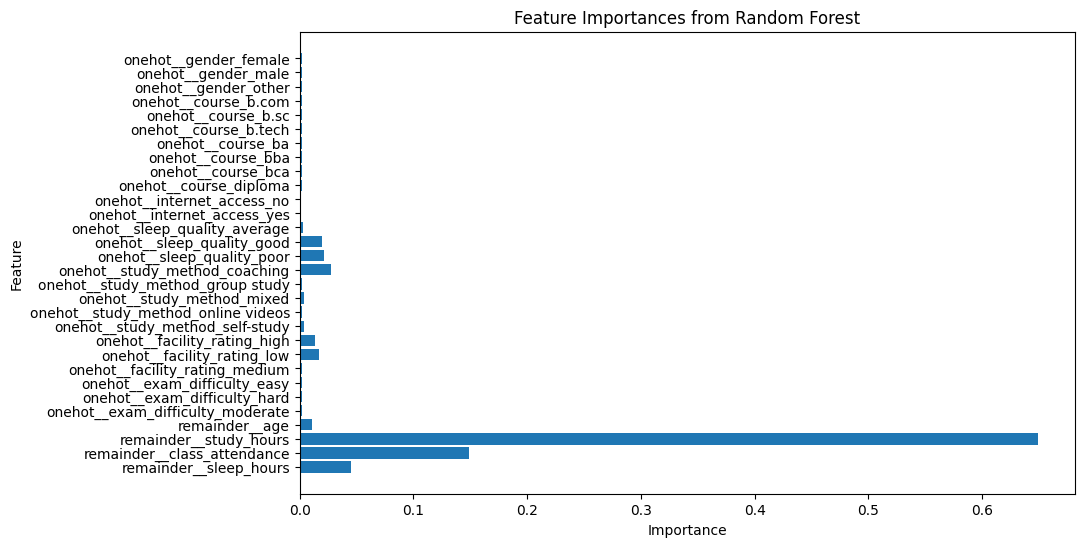

In [129]:
importances = rf.feature_importances_
feature_names = ct.get_feature_names_out()

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [131]:
print("Feature elimination results: \n")
list_rmses = []
for column_drop in df_train.columns:
    df_train_temp = df_train.drop(columns=[column_drop])
    df_val_temp = df_val.drop(columns=[column_drop])
    categorical_columns = df_train_temp.select_dtypes(include=['object']).columns.tolist()
    ct = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ],
        remainder='passthrough')

    X_train = ct.fit_transform(df_train_temp)
    X_val = ct.transform(df_val_temp)

    rf = RandomForestRegressor(n_estimators=260, max_depth=10, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_drop = round((mean_squared_error(y_val, y_pred))**0.5, 3)
    # print("Validation RMSE:", rmse_drop, " after dropping variable ", column_drop)
    list_rmses.append((rmse_drop, column_drop))

list_rmses.sort()
for rmse_drop, column_drop in list_rmses:
    print("Validation RMSE:", rmse_drop, " after dropping variable ", column_drop)
    


Feature elimination results: 

Validation RMSE: 10.095  after dropping variable  age
Validation RMSE: 10.096  after dropping variable  exam_difficulty
Validation RMSE: 10.098  after dropping variable  course
Validation RMSE: 10.098  after dropping variable  internet_access
Validation RMSE: 10.108  after dropping variable  gender
Validation RMSE: 10.322  after dropping variable  sleep_hours
Validation RMSE: 10.524  after dropping variable  facility_rating
Validation RMSE: 10.638  after dropping variable  study_method
Validation RMSE: 10.738  after dropping variable  sleep_quality
Validation RMSE: 11.686  after dropping variable  class_attendance
Validation RMSE: 16.8  after dropping variable  study_hours


In [134]:
from sklearn.inspection import permutation_importance

categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough')

X_train = ct.fit_transform(df_train)
X_val = ct.transform(df_val)

model = RandomForestRegressor(n_estimators=260, max_depth=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

# 3. Calcular Permutation Importance
# Se recomienda usar el conjunto de TEST para ver qué variables ayudan a generalizar
result = permutation_importance(
    model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)

# 4. Organizar y mostrar resultados
importancias = pd.DataFrame({
    'Variable': feature_names,
    'Importancia_Media': result.importances_mean,
    'Desviación_Std': result.importances_std
}).sort_values(by='Importancia_Media', ascending=False)

print(importancias)

                              Variable  Importancia_Media  Desviación_Std
27              remainder__study_hours       1.019602e+00        0.011900
28         remainder__class_attendance       1.939425e-01        0.005201
15       onehot__study_method_coaching       4.292180e-02        0.002615
14          onehot__sleep_quality_poor       2.623064e-02        0.001154
29              remainder__sleep_hours       2.487076e-02        0.001574
13          onehot__sleep_quality_good       2.099919e-02        0.001824
21         onehot__facility_rating_low       1.665170e-02        0.001445
20        onehot__facility_rating_high       1.435572e-02        0.001108
17          onehot__study_method_mixed       1.885756e-03        0.000323
19     onehot__study_method_self-study       1.695538e-03        0.000250
18  onehot__study_method_online videos       8.131528e-04        0.000172
9               onehot__course_diploma       3.091453e-04        0.000156
12       onehot__sleep_quality_average

### 6. Select a Final Model

Best model for RSME Random Forest

In [150]:
# select features based on previous analysis
columnas = ['gender', 'study_hours', 'class_attendance',
       'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating']

categorical_columns = df_train[columnas].select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough')

X_train = ct.fit_transform(df_train[columnas])
X_val = ct.transform(df_val[columnas])

rf = RandomForestRegressor(n_estimators=260, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("Validation RMSE:", round((mean_squared_error(y_val, y_pred))**0.5, 3))

Validation RMSE: 10.079


### 7. Final model evalluation

In [153]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.y.values
df_full_train.drop(['y'], axis=1, inplace=True)

y_test = df_test.y.values
df_test.drop(['y'], axis=1, inplace=True)

In [154]:
feature_selection = ['gender', 'study_hours', 'class_attendance',
       'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating']

In [156]:
categorical_columns = df_full_train[feature_selection].select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough')

X_train = ct.fit_transform(df_full_train[feature_selection])
X_test = ct.transform(df_test[feature_selection])
    
max_depth = 10
n_estimators = 260
rf = RandomForestRegressor(n_estimators=260, max_depth=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_full_train)
y_pred = rf.predict(X_test)
print("Test RMSE:", round((mean_squared_error(y_test, y_pred))**0.5, 3))

Test RMSE: 10.194


In [ ]:
# import requests

# url = 'http://localhost:9696/predict'
# student = {
#     'gender': 'male',
#     'study_hours': 5.66,
#     'class_attendance': 52.8,
#     'sleep_hours': 4.6,
#     'sleep_quality': 'average',
#     'study_method': 'coaching',
#     'facility_rating': 'low'
# }

# response = requests.post(url, json=student).json()
# print(response)

{'exam_score_prediction': 62.46}
